### Declare libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import pandas as pd
pd.set_option("display.max_columns", 30)
import numpy as np
# librerías para graficar
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="white")
import os
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import DMatrix,XGBRegressor, train

### Set folder location of the data and load data 

In [2]:
# you need to change it if you are going to run it on your local machine, writing the folder where the raw data of the challenge is
os.chdir('/Users/iairlinker/Documents/repos/cornershop_test/data')
# Loading pre-processed dataset
model_data = pd.read_csv('interim/model_data.csv', sep=';')
# Transformation for model_data
results = pd.read_csv('interim/results.csv', sep=';')

### Declare functions

In [3]:
# función creada por mi para traer los NA's
def get_na(df):
    qsna=df.shape[0]-df.isnull().sum(axis=0)
    qna=df.isnull().sum(axis=0)
    ppna=round(100*(df.isnull().sum(axis=0)/df.shape[0]),2)
    aux= {'datos sin NAs en q': qsna, 'Na en q': qna ,'Na en %': ppna}
    na=pd.DataFrame(data=aux)
    return na.sort_values(by='Na en %',ascending=False)

In [4]:
model_data.dropna(inplace=True)
get_na(model_data)

,datos sin NAs en q,Na en q,Na en %
order_id,7802,0,0.0
KG,7802,0,0.0
rating,7802,0,0.0
accepted_rate,7802,0,0.0
picking_speed,7802,0,0.0
found_rate,7802,0,0.0
seniority,7802,0,0.0
store_district,7802,0,0.0
stores_location,7802,0,0.0
stores_lng,7802,0,0.0


In [5]:
col_names = ['on_demand', 'KG', 'UN',
             'picking_speed','seniority','found_rate', 'rating',
             'store_district','order_stores_distance']
X = model_data[col_names]
X = pd.get_dummies(X)
y = model_data.total_minutes
y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

### Suppor vector Regression using non-linear Kernels

<https://scikit-learn.org/stable/auto_examples/svm/plot_svm_regression.html>

#### Train with cross-validation to understand posible overfitting

[-11.65705238 -11.56719734 -11.6315127  -11.63023105 -11.66571087
 -11.53621907 -11.59221075 -11.51632376 -11.72591271 -11.69823332]
[-18.73725367 -19.80073869 -19.33231988 -19.70542865 -18.71895745
 -19.42260694 -19.49242036 -20.03688987 -17.69229293 -18.02387723]


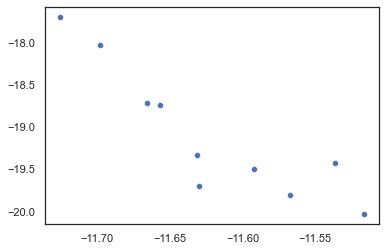

In [6]:
scores = { 'mse': "neg_mean_squared_error",
           'mae': "neg_mean_absolute_error"}

svr_rbf = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)

scores = cross_validate(svr_rbf , X, y, scoring=scores, cv=10,return_train_score=True)
print(scores['train_mae'])
print(scores['test_mae'])
sns.scatterplot(y=scores['test_mae'], x=scores['train_mae'],legend=True);

#### Train and test to report metrics

The mean squared error (MSE) on test set: 699.5543
The mean absolute error (MAE) on test set: 19.2548


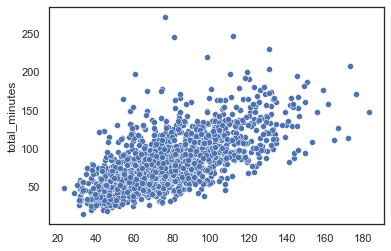

In [7]:
svr_rbf.fit(X_train, y_train)

mse = mean_squared_error(y_test, svr_rbf.predict(X_test))
mae = mean_absolute_error(y_test, svr_rbf.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print("The mean absolute error (MAE) on test set: {:.4f}".format(mae))
sns.scatterplot(y=y_test, x=svr_rbf.predict(X_test),legend=True);

count    1561.000000
mean       19.254777
std        18.138870
min         0.004161
25%         6.770284
50%        15.022766
75%        26.478493
max       196.027291
Name: total_minutes, dtype: float64


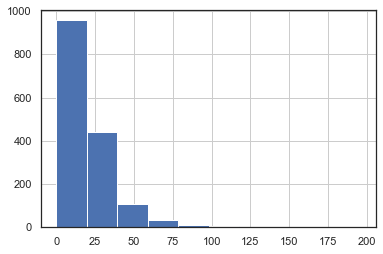

In [8]:
error = abs(svr_rbf.predict(X_test)-y_test)
print(error.describe())
error.hist();

### Gradient Boosting Regressor

<https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor>

#### train with cross-validation

[-14.94275159 -14.9774732  -14.97986849 -14.95219418 -15.07923935
 -14.92011063 -15.02287651 -14.82318227 -15.05503615 -15.07135558]
[-17.42421381 -18.13068983 -18.0520037  -17.94313607 -17.73632563
 -17.94414319 -18.18767616 -18.52200565 -17.02506855 -17.36459331]


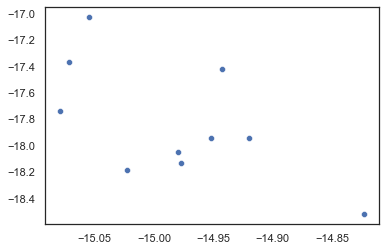

In [9]:
params = {
    "n_estimators": 500,
    "max_depth": 3,
    "min_samples_split": 10,
    "learning_rate": 0.1,
    "loss" : 'ls',
    'subsample': 0.8,
}

scores = { 'mse': "neg_mean_squared_error",
           'mae': "neg_mean_absolute_error"}


reg = GradientBoostingRegressor(**params)


scores = cross_validate(reg, X, y, scoring=scores, cv=10,return_train_score=True)
print(scores['train_mae'])
print(scores['test_mae'])
sns.scatterplot(y=scores['test_mae'], x=scores['train_mae'],legend=True);

#### train and test

0.5550004980535703
The mean squared error (MSE) on test set: 549.9210
The mean absolute error (MAE) on test set: 17.7335


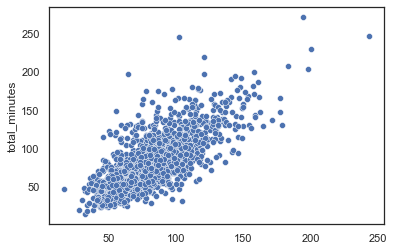

In [10]:
params = {
    "n_estimators": 500,
    "max_depth": 3,
    "min_samples_split": 10,
    "learning_rate": 0.1,
    "loss" : 'ls',
    'subsample': 0.8,
}

reg = GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

print(reg.score(X_test, y_test))
mse = mean_squared_error(y_test, reg.predict(X_test))
mae = mean_absolute_error(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print("The mean absolute error (MAE) on test set: {:.4f}".format(mae))
sns.scatterplot(y=y_test, x=reg.predict(X_test),legend=True);

count    1561.000000
mean       17.733531
std        15.349066
min         0.012399
25%         6.857469
50%        13.907308
75%        24.673083
max       143.270197
Name: total_minutes, dtype: float64


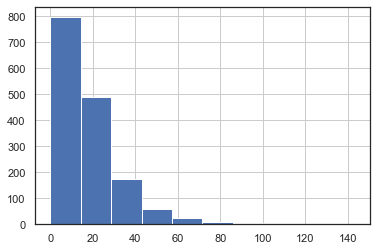

In [11]:
error = abs(reg.predict(X_test)-y_test)
print(error.describe())
error.hist();

### Scikit-Learn Interface for XGboost

Using the cost functions mae and mse  from scikit-learn out of the box

<https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html>

#### Train with cross-validation to understand posible overfitting

[-10.63783877 -10.36545078 -10.77365883 -10.57548996 -10.88562549
 -10.80066527 -10.66406155 -10.35143807 -10.65681776 -10.64760317]
[-18.39311692 -18.84858953 -18.62069666 -18.82231926 -17.80275479
 -18.33384573 -18.58144592 -19.03010457 -17.41381241 -17.80541401]


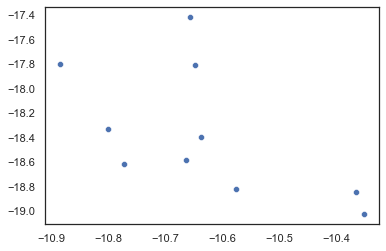

In [12]:
reg = XGBRegressor(
    tree_method="hist",
    eval_metric=mean_absolute_error,
)

scores = { 'mse': "neg_mean_squared_error",
           'mae': "neg_mean_absolute_error"}

scores = cross_validate(reg, X, y, scoring=scores, cv=10,return_train_score=True)
print(scores['train_mae'])
print(scores['test_mae'])
sns.scatterplot(y=scores['test_mae'], x=scores['train_mae'],legend=True);

#### Train and test to report metrics

[0]	validation_0-rmse:64.15622
[1]	validation_0-rmse:48.34481
[2]	validation_0-rmse:38.02672
[3]	validation_0-rmse:31.48413
[4]	validation_0-rmse:27.55970
[5]	validation_0-rmse:25.21339
[6]	validation_0-rmse:23.84495
[7]	validation_0-rmse:22.99765
[8]	validation_0-rmse:22.47946
[9]	validation_0-rmse:22.01566
[10]	validation_0-rmse:21.70113
[11]	validation_0-rmse:21.50275
[12]	validation_0-rmse:21.23406
[13]	validation_0-rmse:21.13949
[14]	validation_0-rmse:21.05599
[15]	validation_0-rmse:20.86104
[16]	validation_0-rmse:20.77806
[17]	validation_0-rmse:20.60510
[18]	validation_0-rmse:20.42058
[19]	validation_0-rmse:20.35053
[20]	validation_0-rmse:20.28293
[21]	validation_0-rmse:20.21853
[22]	validation_0-rmse:20.11589
[23]	validation_0-rmse:20.02065
[24]	validation_0-rmse:19.95946
[25]	validation_0-rmse:19.93640
[26]	validation_0-rmse:19.78294
[27]	validation_0-rmse:19.69664
[28]	validation_0-rmse:19.63693
[29]	validation_0-rmse:19.57447
[30]	validation_0-rmse:19.50244
[31]	validation_0-

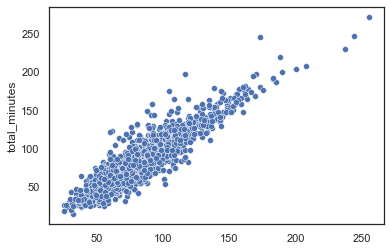

In [13]:
reg = XGBRegressor(
    tree_method="hist",
    eval_metric=mean_absolute_error,
)

reg.fit(X, y, eval_set=[(X, y)])

print(reg.score(X_test, y_test))
mse = mean_squared_error(y_test, reg.predict(X_test))
mae = mean_absolute_error(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print("The mean absolute error (MAE) on test set: {:.4f}".format(mae))
sns.scatterplot(y=y_test, x=reg.predict(X_test),legend=True);

count    1561.000000
mean       10.714812
std         9.548804
min         0.010126
25%         3.723374
50%         8.502704
75%        14.865080
max        81.027007
Name: total_minutes, dtype: float64


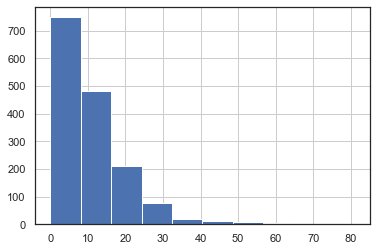

In [14]:
error = abs(reg.predict(X_test)-y_test)
print(error.describe())
error.hist();